## Project 2. Part 2 (Explore, Clean & Model)

In [513]:
import re
import pickle
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from diagnostic_plots import diagnostic_plots

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
%matplotlib inline

### Define some useful functions

In [514]:
#To clean the engine_size column (convert into floats)
def clean_engine(series):
    """Takes a series of strings and converts them into floats where possible.
    Returns a list of floats."""
    values = car_ad_dataset['Engine_Size']
    new_values = []
    for value in values:
        try:
            val = float(value)
        except:
            val = np.NaN
        new_values.append(val)
    return new_values

#Clean up the price column
def clean_price(series):
    """Takes a series of strings, cleans them from text and converts them into floats where possible.
    Returns a list of floats."""
    values = series.str.split('€').str[0]
    new_values = []
    for value in values:
        try:
            val = float(re.sub(r'\s+', '', value))
        except:
            val = np.NaN
        new_values.append(val)
    return new_values

#Clean up the mileage column
def clean_kms(series):
    """Takes a series of strings, cleans them from text and converts them into integers where possible.
    Returns a list of integers."""
    values = series.str.split('km').str[0]
    new_values = []
    for value in values:
        try:
            val = int(re.sub(r'\s+', '', value))
        except:
            val = np.NaN
        new_values.append(val)
    return new_values

#Clean up the Number of Doors column
def clean_door_count(series):
    """Takes a series of strings, cleans them from text and converts them into integers where possible.
    Returns a list of integers."""
    values = series.str.split('/').str[0]
    new_values = []
    for value in values:
        try:
            val = int(value)
        except:
            val = np.NaN
        new_values.append(val)
    return new_values

#Convert 'Fuel type' to numeric value (Petrol = 0, Diesel = 1) !If the car is electric, it assigns NaN
def fuel_bool(series):
    """Takes a series with strings and converts them to a boolean representation of 0 for Petrol and 1 for Diesel.
    Returns a list of integers (0, 1)."""
    values = series
    new_values = []
    for value in values:
        if value == 'Petrol' or value == 'Petrol / LPG':
            val = int(0)
            new_values.append(val)
        elif value == 'Diesel' or value == 'Diesel / gas':
            val = int(1)
            new_values.append(val)
        else:
            val = np.NaN
            new_values.append(val)
    return new_values

def gearbox_bool(series):
    """Takes a series with strings and converts them to a boolean representation of 0 for Manual and 1 for Automatic.
    Returns a list of integers (0, 1)."""
    values = series
    new_values = []
    for value in values:
        if value == 'Manual':
            val = int(0)
            new_values.append(val)
        elif value == 'Automatic':
            val = int(1)
            new_values.append(val)
        else:
            val = np.NaN
            new_values.append(val)
    return new_values

def get_white_cars(series):
    """Takes a series with strings and converts them to a boolean representation of 0 for non-White and 1 for White.
    Returns a list of integers (0, 1)."""
    values = series
    new_values = []
    for value in values:
        if value == 'White':
            val = int(1)
            new_values.append(val)
        else:
            val = int(0)
            new_values.append(val)
    return new_values

def get_red_cars(series):
    """Takes a series with strings and converts them to a boolean representation of 0 for non-Red and 1 for Red.
    Returns a list of integers (0, 1)."""
    values = series
    new_values = []
    for value in values:
        if value == 'Red / crimson':
            val = int(1)
            new_values.append(val)
        else:
            val = int(0)
            new_values.append(val)
    return new_values

def group_body_types(series):
    """Takes a series of body types and groups them to categories.
    Returns a list of tuples."""
    body_type_dict = {'Other': ('Other', 'Limousine'), 'Limousine':('Other', 'Limousine'), 'Coupe':('Coupe'), 'Hatchback':('Hatchback'), 'Saloon / sedan':('Saloon / sedan', 'Convertible'), 'Convertible':('Saloon / sedan', 'Convertible'), 'Wagon':('Wagon'), 'SUV / off-road':('SUV / off-road', 'MPV / minivan', 'Commercial', 'Pick-up'), 'MPV / minivan':('SUV / off-road', 'MPV / minivan', 'Commercial', 'Pick-up'), 'Commercial':('SUV / off-road', 'MPV / minivan', 'Commercial', 'Pick-up'), 'Pick-up':('SUV / off-road', 'MPV / minivan', 'Commercial', 'Pick-up')}
    values = series
    new_values = []
    for value in values:
        val = body_type_dict[value]
        new_values.append(val)
    return new_values
    
def numeric_body_type(series):
    """Takes a series of body types and converts them into numbers from smallest to largest.
    Returns a list of integers"""
    body_types = {('Other', 'Limousine'):np.NaN, ('Coupe'):2, ('Hatchback'):3, ('Saloon / sedan', 'Convertible'):4, ('Wagon'):5, ('SUV / off-road', 'MPV / minivan', 'Commercial', 'Pick-up'):6}
    values = series
    new_values = []
    for value in values:
        try:
            val = body_types[value]
            new_values.append(val)
        except:
            val = np.NaN
            new_values.append(val)
    return new_values

def get_german_make(series):
    """Takes a series of car makers and marks as 1 the cars that are German. 
     Returns a list of 1s and 0s."""
    germany = ['BMW', 'Audi', 'Open', 'Mercedes-Benz', 'Porsche', 'Volkswagen', 'Ford']
    values = series
    new_values = []
    for value in values:
        if value in germany:
            new_values.append(1)
        else:
            new_values.append(0)
    return new_values
            
def get_japanese_make(series):
    """Takes a series of car makers and marks as 1 the cars that are Japanese. 
     Returns a list of 1s and 0s."""
    japan = ['Toyota', 'Mazda', 'Honda', 'Nissan', 'Mitsubishi', 'Suzuki', 'Lexus']
    values = series
    new_values = []
    for value in values:
        if value in japan:
            new_values.append(1)
        else:
            new_values.append(0)
    return new_values

def get_french_make(series):
    """Takes a series of car makers and marks as 1 the cars that are French. 
     Returns a list of 1s and 0s."""
    france = ['Renault', 'Citroen', 'Peugeot']
    values = series
    new_values = []
    for value in values:
        if value in france:
            new_values.append(1)
        else:
            new_values.append(0)
    return new_values


def get_bmw(series):
    """Takes a series of car makers and marks BMWs as 1, others 0. 
     Returns a list of 1s and 0s."""
    values = series
    new_values = []
    for value in values:
        if value == 'BMW':
            new_values.append(1)
        else:
            new_values.append(0)
    return new_values

def get_mb(series):
    """Takes a series of car makers and marks Mercedes-Benz as 1, others 0. 
     Returns a list of 1s and 0s."""
    values = series
    new_values = []
    for value in values:
        if value == 'Mercedes-Benz':
            new_values.append(1)
        else:
            new_values.append(0)
    return new_values

### Unpickle the file

In [515]:
with open('car_ad_dataset_bigger.pkl', 'rb') as picklefile:
    car_ad_dataset = pickle.load(picklefile)
    
#Verify that the result is as desired
car_ad_dataset.head()

,Audio/video equipment,Body type,Climate control,Color,Combined,Damage,Date of manufacture,Driven wheels,Electronics,Engine,...,Price in Lithuania,Safety,Security,Special price,Steering wheel,Tuning (improvements),Urban,VIN check,VIN number,Wheel size
0,"CD player,MP3 player,Sound amplifier,Subwoofer",Other,NaN,White,NaN,No damages,1996-07,Front wheel drive (FWD),NaN,"2400 cm³, 74 HP (55kW)",...,2 050 €\n \n Sužinokite įmoką\n ...,"ABS,Airbags","Central locking,Alarm",NaN,Left hand drive (LHD),Tuned interior,NaN,\n \n Check vehicle history\...,NaN,R15
1,"CD player,AUX input,Navigation/GPS,Handsfree kit",Wagon,Climate control,Black,NaN,No damages,2018-02,All wheel (4х4),"Electric mirrors,Electric boot lid,Galinio vai...","1995 cm³, 190 HP (139kW)",...,44 900 €,"ABS,Traction control system,ESP iElectronic st...","Central locking,Immobilizer,Alarm",NaN,Left hand drive (LHD),NaN,NaN,\n \n Check vehicle history\...,NaN,NaN
2,NaN,Coupe,None,Blue,NaN,No damages,1992,Rear wheel drive (RWD),Electric windows,"1998 cm³, 156 HP (115kW)",...,4 400 €\n \n Sužinokite įmoką\n ...,NaN,NaN,NaN,Left hand drive (LHD),NaN,NaN,\n \n Check vehicle history\...,NaN,R17
3,CD player,MPV / minivan,Air conditioning,NaN,NaN,No damages,2008-04,Front wheel drive (FWD),"Electric mirrors,Electric windows,Automatic he...","2200 cm³, 135 HP (100kW)",...,4 400 €\n \n Sužinokite įmoką\n ...,Airbags,"Central locking,Immobilizer",NaN,Left hand drive (LHD),NaN,NaN,\n \n Check vehicle history\...,NaN,R15
4,"CD player,MP3 player,CD changer,Subwoofer,USB ...",Saloon / sedan,Climate control,Gray / silver,9.50,No damages,2009-11,Front wheel drive (FWD),"Electric mirrors,Electric windows,Automatic he...","2354 cm³, 201 HP (148kW)",...,7 990 €\n \n Sužinokite įmoką\n ...,"ABS,ESP iElectronic stability program$(""#rel_E...","Central locking,Immobilizer,Alarm",NaN,Left hand drive (LHD),NaN,10.50,\n \n Check vehicle history\...,JHMCU26809C230972,NaN


In [516]:
#Check out the shape and get info
print('The shape is:', str(car_ad_dataset.shape), '\n');
car_ad_dataset.info()

The shape is: (3879, 37) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3879 entries, 0 to 3878
Data columns (total 37 columns):
Audio/video equipment         941 non-null object
Body type                     1388 non-null object
Climate control               874 non-null object
Color                         1134 non-null object
Combined                      543 non-null object
Damage                        1388 non-null object
Date of manufacture           1388 non-null object
Driven wheels                 1037 non-null object
Electronics                   1121 non-null object
Engine                        1366 non-null object
Engine_Size                   1388 non-null object
Euro standard                 440 non-null object
Export price                  382 non-null object
Exterior                      1114 non-null object
Extra-urban                   548 non-null object
First registration country    682 non-null object
Fuel type                     1388 non-null object
Gearbo

In [517]:
#Explore the dataset
car_ad_dataset.count().sort_values(ascending = False)

Gearbox                       1388
Number of doors               1388
Body type                     1388
Engine_Size                   1388
Steering wheel                1388
Damage                        1388
Date of manufacture           1388
Fuel type                     1388
Make_Model                    1388
Price in Lithuania            1387
VIN check                     1378
Engine                        1366
Interior                      1141
Color                         1134
Electronics                   1121
Exterior                      1114
Mileage                       1067
Safety                        1053
Driven wheels                 1037
Number of seats                975
Audio/video equipment          941
Security                       896
Other features                 895
Climate control                874
Wheel size                     729
MOT test expiry                692
First registration country     682
Extra-urban                    548
Combined            

### Clean the dataset

**Initial cleaning and formatting**

In [518]:
#Check out the records without mileage 
#car_ad_dataset.iloc[28]
#Conclusion: they are indeed legit

In [519]:
#Clean up the price column and convert to a float
car_ad_dataset['Price'] = clean_price(car_ad_dataset['Price in Lithuania'])

In [520]:
#Split the Make_Model column
car_ad_dataset['Make'], car_ad_dataset['Model'] = car_ad_dataset['Make_Model'].str.split(' ', 1).str

In [521]:
#Group Makes into countries
car_ad_dataset['Is_German'] = get_german_make(car_ad_dataset['Make'])

car_ad_dataset['Is_French'] = get_french_make(car_ad_dataset['Make'])

car_ad_dataset['Is_Japanese'] = get_japanese_make(car_ad_dataset['Make'])

car_ad_dataset['Is_BMW'] = get_bmw(car_ad_dataset['Make'])

car_ad_dataset['Is_Mercedes_Benz'] = get_mb(car_ad_dataset['Make'])

In [522]:
#Clean up the Engine_Size column from l.
car_ad_dataset['Engine_Size'] = car_ad_dataset['Engine_Size'].str.split(' ', 2).str[1]
car_ad_dataset['Engine_Size_l'] = clean_engine(car_ad_dataset['Engine_Size'])

In [523]:
#Clean the Engine column
#Some of the cars don't have the cm3, so instead this takes HP or kW, will have to drop those later on!!!
#car_ad_dataset['Engine_cm3'] = pd.to_numeric(car_ad_dataset['Engine'].str.split(' ').str[0])

In [524]:
#Only keep the Year of manufacture
car_ad_dataset['Year_of_manufacture'] = pd.to_numeric(car_ad_dataset['Date of manufacture'].str[:4])

In [525]:
#Clean up the milage column to remove 'km'
car_ad_dataset['Mileage_km'] = clean_kms(car_ad_dataset['Mileage'])

In [526]:
#Clean up the number of doors to remove /second number
car_ad_dataset['Door_count'] = clean_door_count(car_ad_dataset['Number of doors'])

In [527]:
#Convert Fuel type column to boolean (0,1)
car_ad_dataset['Fuel type'] = fuel_bool(car_ad_dataset['Fuel type'])

In [528]:
car_ad_dataset['Gearbox'] = gearbox_bool(car_ad_dataset['Gearbox'])
#car_ad_dataset['Gearbox']

In [529]:
car_ad_dataset['Is_White'] = get_white_cars(car_ad_dataset['Color'])
#car_ad_dataset['Is_White']

In [530]:
car_ad_dataset['Is_Red'] = get_red_cars(car_ad_dataset['Color'])
#car_ad_dataset['Is_Red']

In [531]:
#Rename the Fuel type column
car_ad_dataset = car_ad_dataset.rename(columns = {'Fuel type': 'Fuel_type'})

In [532]:
#Remove cars that are damaged
car_ad_dataset = car_ad_dataset[car_ad_dataset['Damage'] == 'No damages']
car_ad_dataset.drop(columns = ['Damage'], inplace = True)

#Remove cars that are not Left hand drive
car_ad_dataset = car_ad_dataset[car_ad_dataset['Steering wheel'] == 'Left hand drive (LHD)']
car_ad_dataset.drop(columns = ['Steering wheel'], inplace = True)

#car_ad_dataset.head()

In [533]:
#Generalize body types
car_ad_dataset['Body_type_group'] = group_body_types(car_ad_dataset['Body type'])
car_ad_dataset['Body_type'] = numeric_body_type(car_ad_dataset['Body_type_group'])

In [534]:
#car_ad_dataset['Make'].value_counts()

In [535]:
#car_ad_dataset['Color'].value_counts()

In [536]:
#Let's have a look
car_ad_dataset.count().sort_values(ascending = False)

Gearbox                       1264
Is_French                     1264
Date of manufacture           1264
Body_type_group               1264
Number of doors               1264
Body type                     1264
Make                          1264
Model                         1264
Is_German                     1264
Is_Japanese                   1264
Is_BMW                        1264
Is_Mercedes_Benz              1264
Make_Model                    1264
Year_of_manufacture           1264
Engine_Size                   1264
Is_White                      1264
Is_Red                        1264
Price in Lithuania            1263
Price                         1263
Door_count                    1260
Body_type                     1258
VIN check                     1254
Engine                        1246
Fuel_type                     1239
Engine_Size_l                 1227
Interior                      1077
Electronics                   1057
Exterior                      1054
Color               

**Shorten the dataset & re-evaluate**

In [537]:
#Shorten the dataset by picking the most logical features
short_car_ad_dataset = car_ad_dataset[['Price', 'Year_of_manufacture', 'Engine_Size_l', 'Gearbox', 'Mileage_km', 'Body_type', 'Door_count', 'Fuel_type', 'Is_White', 'Is_Red', 'Is_German', 'Is_BMW', 'Is_Mercedes_Benz', 'Is_Japanese', 'Is_French']]
short_car_ad_dataset.head()

,Price,Year_of_manufacture,Engine_Size_l,Gearbox,Mileage_km,Body_type,Door_count,Fuel_type,Is_White,Is_Red,Is_German,Is_BMW,Is_Mercedes_Benz,Is_Japanese,Is_French
0,2050.0,1996.0,2.4,0.0,450000.0,NaN,4.0,1.0,1,0,1,0,0,0,0
1,44900.0,2018.0,2.0,1.0,8100.0,5.0,4.0,1.0,0,0,1,1,0,0,0
2,4400.0,1992.0,2.0,0.0,270000.0,2.0,2.0,0.0,0,0,0,0,0,1,0
3,4400.0,2008.0,2.2,0.0,222000.0,6.0,4.0,1.0,0,0,0,0,0,1,0
4,7990.0,2009.0,2.4,1.0,129977.0,4.0,4.0,0.0,0,0,0,0,0,1,0


In [538]:
#Get the info on the shorten dataset
short_car_ad_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1264 entries, 0 to 1966
Data columns (total 15 columns):
Price                  1263 non-null float64
Year_of_manufacture    1264 non-null float64
Engine_Size_l          1227 non-null float64
Gearbox                1264 non-null float64
Mileage_km             977 non-null float64
Body_type              1258 non-null float64
Door_count             1260 non-null float64
Fuel_type              1239 non-null float64
Is_White               1264 non-null int64
Is_Red                 1264 non-null int64
Is_German              1264 non-null int64
Is_BMW                 1264 non-null int64
Is_Mercedes_Benz       1264 non-null int64
Is_Japanese            1264 non-null int64
Is_French              1264 non-null int64
dtypes: float64(8), int64(7)
memory usage: 158.0 KB


**Clean the small dataset of NaN values**

In [539]:
#Drop all the cars that are missing at least one of the values
clean_car_ad_dataset = short_car_ad_dataset.dropna(how = 'any')

#And review again
clean_car_ad_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 927 entries, 1 to 1966
Data columns (total 15 columns):
Price                  927 non-null float64
Year_of_manufacture    927 non-null float64
Engine_Size_l          927 non-null float64
Gearbox                927 non-null float64
Mileage_km             927 non-null float64
Body_type              927 non-null float64
Door_count             927 non-null float64
Fuel_type              927 non-null float64
Is_White               927 non-null int64
Is_Red                 927 non-null int64
Is_German              927 non-null int64
Is_BMW                 927 non-null int64
Is_Mercedes_Benz       927 non-null int64
Is_Japanese            927 non-null int64
Is_French              927 non-null int64
dtypes: float64(8), int64(7)
memory usage: 115.9 KB


In [540]:
#Let's have a look again
clean_car_ad_dataset.head()

,Price,Year_of_manufacture,Engine_Size_l,Gearbox,Mileage_km,Body_type,Door_count,Fuel_type,Is_White,Is_Red,Is_German,Is_BMW,Is_Mercedes_Benz,Is_Japanese,Is_French
1,44900.0,2018.0,2.0,1.0,8100.0,5.0,4.0,1.0,0,0,1,1,0,0,0
2,4400.0,1992.0,2.0,0.0,270000.0,2.0,2.0,0.0,0,0,0,0,0,1,0
3,4400.0,2008.0,2.2,0.0,222000.0,6.0,4.0,1.0,0,0,0,0,0,1,0
4,7990.0,2009.0,2.4,1.0,129977.0,4.0,4.0,0.0,0,0,0,0,0,1,0
6,4350.0,2002.0,2.7,1.0,228443.0,6.0,4.0,1.0,0,0,1,0,1,0,0


**Explore target variable**

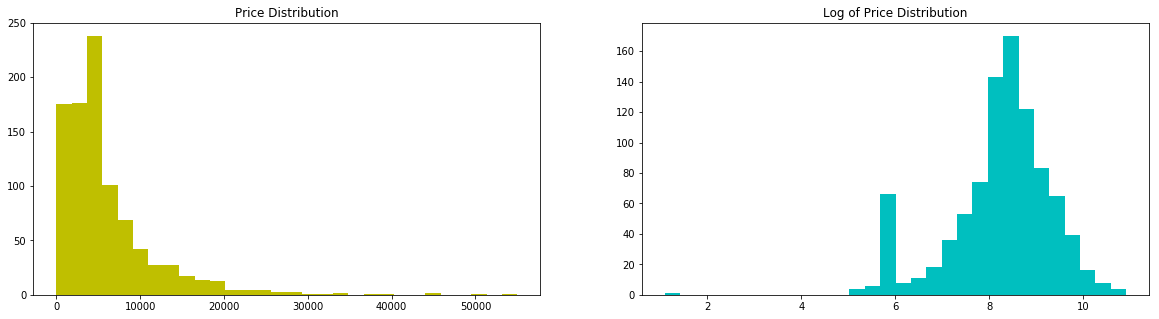

In [541]:
#Plot Price histogram (to check the distribution)
fig = plt.figure(figsize = (20, 5))
plt.subplot(1, 2, 1)
plt.hist(clean_car_ad_dataset['Price'], bins=30, color = 'y')
plt.title('Price Distribution')

plt.subplot(1, 2, 2)
plt.hist(np.log(clean_car_ad_dataset['Price']), bins=30, color = 'c')
plt.title('Log of Price Distribution')
plt.show()

In [542]:
#Let's find the minimum and maximum prices
print(clean_car_ad_dataset['Price'].min())
print(clean_car_ad_dataset['Price'].max())

3.0
55000.0


In [543]:
#What is a reasonable lower threshold to set for the price?
clean_car_ad_dataset[clean_car_ad_dataset['Price'] <= 200.0]
clean_car_ad_dataset[clean_car_ad_dataset['Price'] >= 40000]

,Price,Year_of_manufacture,Engine_Size_l,Gearbox,Mileage_km,Body_type,Door_count,Fuel_type,Is_White,Is_Red,Is_German,Is_BMW,Is_Mercedes_Benz,Is_Japanese,Is_French
1,44900.0,2018.0,2.0,1.0,8100.0,5.0,4.0,1.0,0,0,1,1,0,0,0
1754,44990.0,2017.0,2.0,1.0,23000.0,4.0,4.0,0.0,1,0,1,0,1,0,0
1755,50000.0,2015.0,3.0,1.0,80000.0,6.0,4.0,1.0,0,0,1,1,0,0,0
1756,55000.0,2014.0,3.5,1.0,87997.0,6.0,4.0,1.0,1,0,1,0,1,0,0


In [544]:
#Choosing the lower bound to be €200 (not incl.) and upper bound €40k (incl.)
clean_car_ad_dataset = clean_car_ad_dataset[(clean_car_ad_dataset['Price'] > 200.0) & (clean_car_ad_dataset['Price'] <= 40000.0)]
clean_car_ad_dataset.head()

,Price,Year_of_manufacture,Engine_Size_l,Gearbox,Mileage_km,Body_type,Door_count,Fuel_type,Is_White,Is_Red,Is_German,Is_BMW,Is_Mercedes_Benz,Is_Japanese,Is_French
2,4400.0,1992.0,2.0,0.0,270000.0,2.0,2.0,0.0,0,0,0,0,0,1,0
3,4400.0,2008.0,2.2,0.0,222000.0,6.0,4.0,1.0,0,0,0,0,0,1,0
4,7990.0,2009.0,2.4,1.0,129977.0,4.0,4.0,0.0,0,0,0,0,0,1,0
6,4350.0,2002.0,2.7,1.0,228443.0,6.0,4.0,1.0,0,0,1,0,1,0,0
8,9800.0,2011.0,3.0,1.0,226000.0,5.0,4.0,1.0,0,0,1,1,0,0,0


**Add a column for log price**

In [364]:
clean_car_ad_dataset['Price_log'] = np.log(clean_car_ad_dataset['Price'])
clean_car_ad_dataset.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Price,Year_of_manufacture,Engine_Size_l,Gearbox,Mileage_km,Body_type,Door_count,Fuel_type,Is_White,Is_Red,Is_German,Is_BMW,Is_Mercedes_Benz,Is_Japanese,Is_French,Price_log
1,44900.0,2018.0,2.0,1.0,8100.0,5.0,4.0,1.0,0,0,1,1,0,0,0,10.712193
2,4400.0,1992.0,2.0,0.0,270000.0,2.0,2.0,0.0,0,0,0,0,0,1,0,8.389360
3,4400.0,2008.0,2.2,0.0,222000.0,6.0,4.0,1.0,0,0,0,0,0,1,0,8.389360
4,7990.0,2009.0,2.4,1.0,129977.0,4.0,4.0,0.0,0,0,0,0,0,1,0,8.985946
6,4350.0,2002.0,2.7,1.0,228443.0,6.0,4.0,1.0,0,0,1,0,1,0,0,8.377931


**Explore the features**

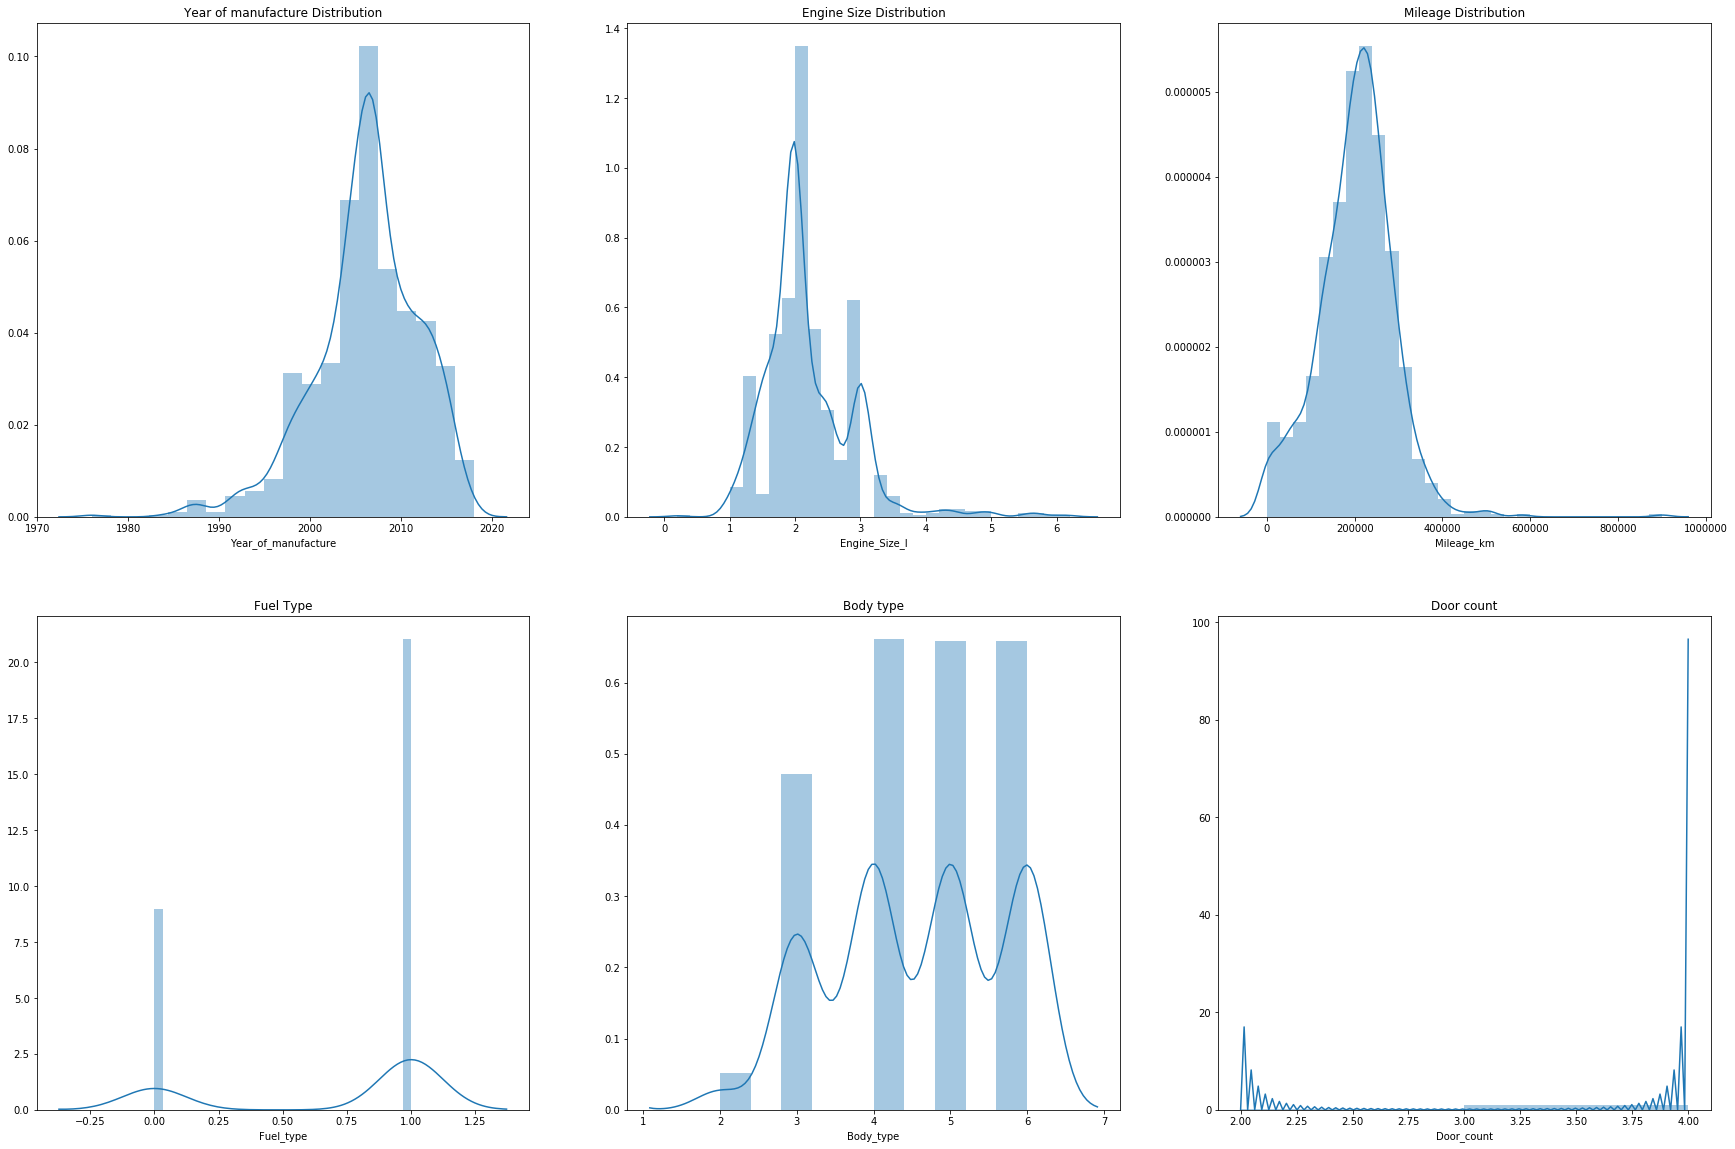

In [365]:
#Create a 2 x 3 plot matrix
fig = plt.figure(figsize = (30, 20))

#Distribution of years
plt.subplot(2, 3, 1)
sns.distplot(clean_car_ad_dataset["Year_of_manufacture"], bins = 20); 
plt.title('Year of manufacture Distribution')

#Distribution of Engine Size 
plt.subplot(2, 3, 2)
sns.distplot(clean_car_ad_dataset["Engine_Size_l"], bins = 30); 
plt.title('Engine Size Distribution')

#Distribution of Mileage 
plt.subplot(2, 3, 3)
sns.distplot(clean_car_ad_dataset["Mileage_km"], bins = 30); 
plt.title('Mileage Distribution')

#Distribution of Fuel Type
plt.subplot(2, 3, 4)
sns.distplot(clean_car_ad_dataset["Fuel_type"], bins = 30); 
plt.title('Fuel Type')

#Distribution of Body Type
plt.subplot(2, 3, 5)
sns.distplot(clean_car_ad_dataset["Body_type"]); 
plt.title('Body type')

#Distribution of Door count
plt.subplot(2, 3, 6)
sns.distplot(clean_car_ad_dataset["Door_count"], bins = 2); 
plt.title('Door count');


Text(0.5,1,'Mileage Distribution')

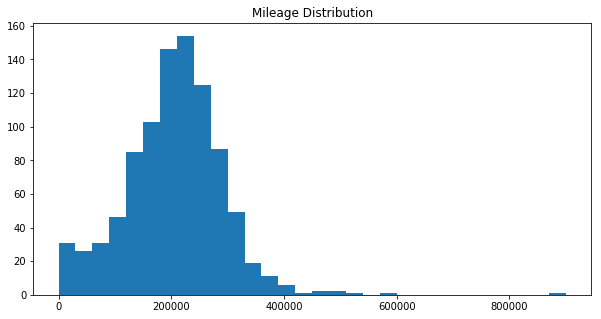

In [366]:
#Plot Mileage histogram (to check the distribution)
plt.figure(figsize = (10, 5))
plt.hist(clean_car_ad_dataset['Mileage_km'], bins=30)
plt.title('Mileage Distribution')


In [367]:
#Check Mileage outliers
#clean_car_ad_dataset[clean_car_ad_dataset['Mileage_km'] >= 600000.0]
clean_car_ad_dataset = clean_car_ad_dataset[clean_car_ad_dataset['Mileage_km'] <= 600000.0]
#clean_car_ad_dataset.head()

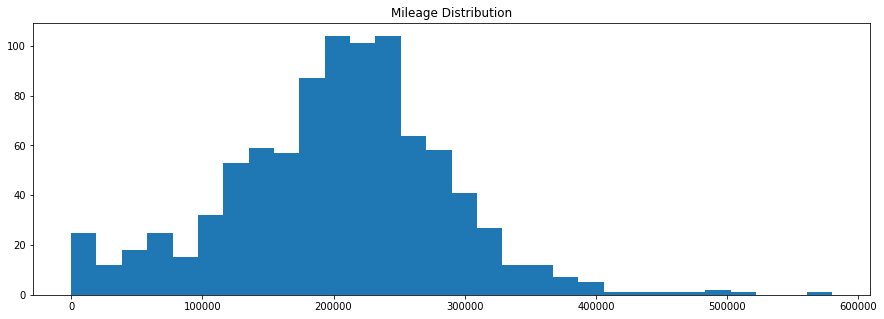

In [368]:
#Let's plot Mileage histogram again, after removing outliers (to check the distribution)
plt.figure(figsize = (15, 5))
plt.hist(clean_car_ad_dataset['Mileage_km'], bins=30)
plt.title('Mileage Distribution');

**Let's look at those massive engines**

In [369]:
#Checked Engine Size outliers
#clean_car_ad_dataset[clean_car_ad_dataset['Engine_Size_l'] >= 5.0]
#clean_car_ad_dataset['Engine_Size_l'].value_counts()
#clean_car_ad_dataset = clean_car_ad_dataset[clean_car_ad_dataset['Engine_Size_l'] <= 5.0]
#clean_car_ad_dataset.head()

**Removing very old & newcars (year of manufacture before 1990 and after 2016)**

In [467]:
#Checked Year_of_manufacture outliers
#clean_car_ad_dataset[clean_car_ad_dataset['Year_of_manufacture'] <= 1990.0]
clean_car_ad_dataset = clean_car_ad_dataset[(clean_car_ad_dataset['Year_of_manufacture'] >= 1995.0) & (clean_car_ad_dataset['Year_of_manufacture'] < 2017.0)]
#clean_car_ad_dataset.head()

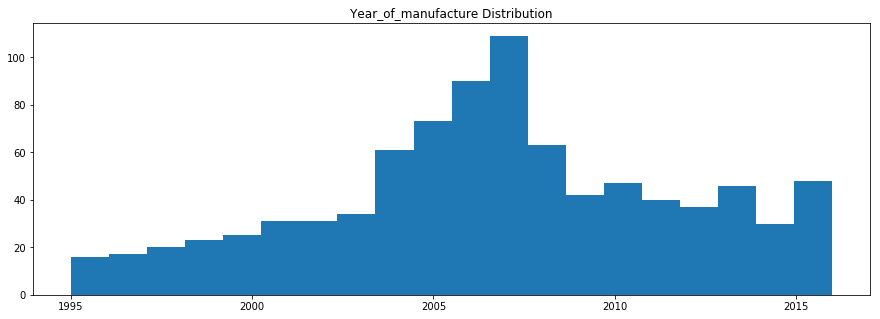

In [468]:
#Let's plot Year_of_manufacture histogram again, after removing outliers (to check the distribution)
plt.figure(figsize = (15, 5))
plt.hist(clean_car_ad_dataset['Year_of_manufacture'], bins=20)
plt.title('Year_of_manufacture Distribution');

**Let's re-assess a after cleanup**

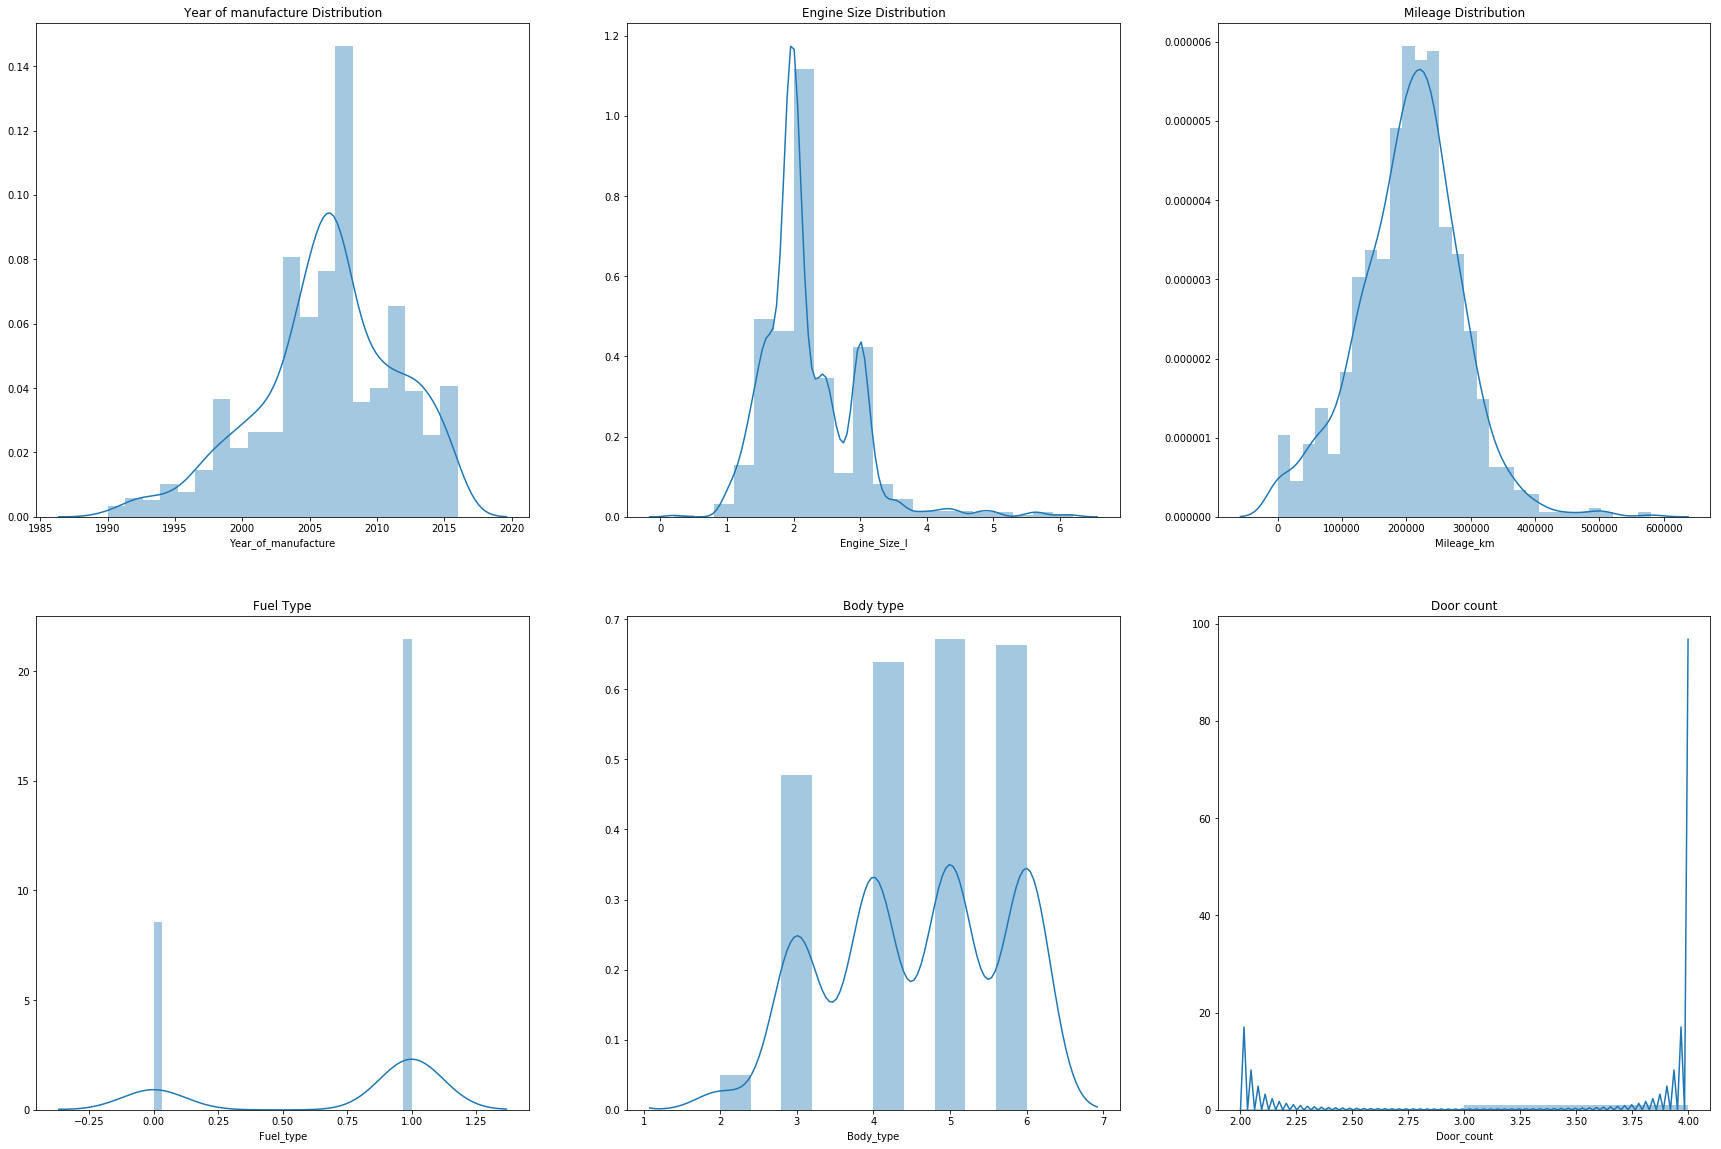

In [428]:
#Create a 2 x 3 plot matrix
fig = plt.figure(figsize = (30, 20))

#Distribution of years
plt.subplot(2, 3, 1)
sns.distplot(clean_car_ad_dataset["Year_of_manufacture"], bins = 20); 
plt.title('Year of manufacture Distribution')

#Distribution of Engine Size 
plt.subplot(2, 3, 2)
sns.distplot(clean_car_ad_dataset["Engine_Size_l"], bins = 20); 
plt.title('Engine Size Distribution')

#Distribution of Mileage 
plt.subplot(2, 3, 3)
sns.distplot(clean_car_ad_dataset["Mileage_km"], bins = 30); 
plt.title('Mileage Distribution')

#Distribution of Fuel Type
plt.subplot(2, 3, 4)
sns.distplot(clean_car_ad_dataset["Fuel_type"], bins = 30); 
plt.title('Fuel Type')

#Distribution of Body Type
plt.subplot(2, 3, 5)
sns.distplot(clean_car_ad_dataset["Body_type"]); 
plt.title('Body type')

#Distribution of Door count
plt.subplot(2, 3, 6)
sns.distplot(clean_car_ad_dataset["Door_count"], bins = 2); 
plt.title('Door count');


### More analysis

In [378]:
#Check the correlation between different variables
clean_car_ad_dataset.corr()

,Price,Year_of_manufacture,Engine_Size_l,Gearbox,Mileage_km,Body_type,Door_count,Fuel_type,Is_White,Is_Red,Is_German,Is_BMW,Is_Mercedes_Benz,Is_Japanese,Is_French,Price_log
Price,1.000000,0.653833,0.311573,0.425999,-0.375655,0.206180,0.090302,0.039728,0.243569,-0.065618,0.193518,0.192661,0.099355,-0.070590,-0.129133,0.774371
Year_of_manufacture,0.653833,1.000000,-0.031533,0.252566,-0.443565,0.167012,0.144598,0.159925,0.184783,-0.144693,-0.014609,0.043430,-0.056502,-0.020652,-0.071639,0.811331
Engine_Size_l,0.311573,-0.031533,1.000000,0.500850,0.140713,0.217790,0.120173,0.002408,0.002703,-0.064484,0.256096,0.296235,0.269018,-0.111631,-0.163847,0.326326
Gearbox,0.425999,0.252566,0.500850,1.000000,-0.041392,0.169591,0.114068,-0.017455,0.094497,-0.078410,0.241445,0.206349,0.200465,-0.187751,-0.106893,0.453060
Mileage_km,-0.375655,-0.443565,0.140713,-0.041392,1.000000,0.065919,0.121405,0.319503,-0.128391,-0.120272,0.140043,0.119774,0.060217,-0.058698,-0.053989,-0.307951
Body_type,0.206180,0.167012,0.217790,0.169591,0.065919,1.000000,0.366989,0.237199,0.096879,-0.089264,0.001762,0.033410,-0.042060,-0.000292,-0.082822,0.247583
Door_count,0.090302,0.144598,0.120173,0.114068,0.121405,0.366989,1.000000,0.228513,-0.056642,-0.094990,0.067856,0.066197,-0.008275,-0.017829,-0.141590,0.175910
Fuel_type,0.039728,0.159925,0.002408,-0.017455,0.319503,0.237199,0.228513,1.000000,-0.058087,-0.163671,0.100700,0.043729,0.042836,-0.129551,-0.067830,0.159031
Is_White,0.243569,0.184783,0.002703,0.094497,-0.128391,0.096879,-0.056642,-0.058087,1.000000,-0.051516,-0.011903,0.001989,-0.012750,-0.004012,0.014366,0.150251
Is_Red,-0.065618,-0.144693,-0.064484,-0.078410,-0.120272,-0.089264,-0.094990,-0.163671,-0.051516,1.000000,-0.047747,-0.058600,-0.046972,0.024118,0.023069,-0.163390


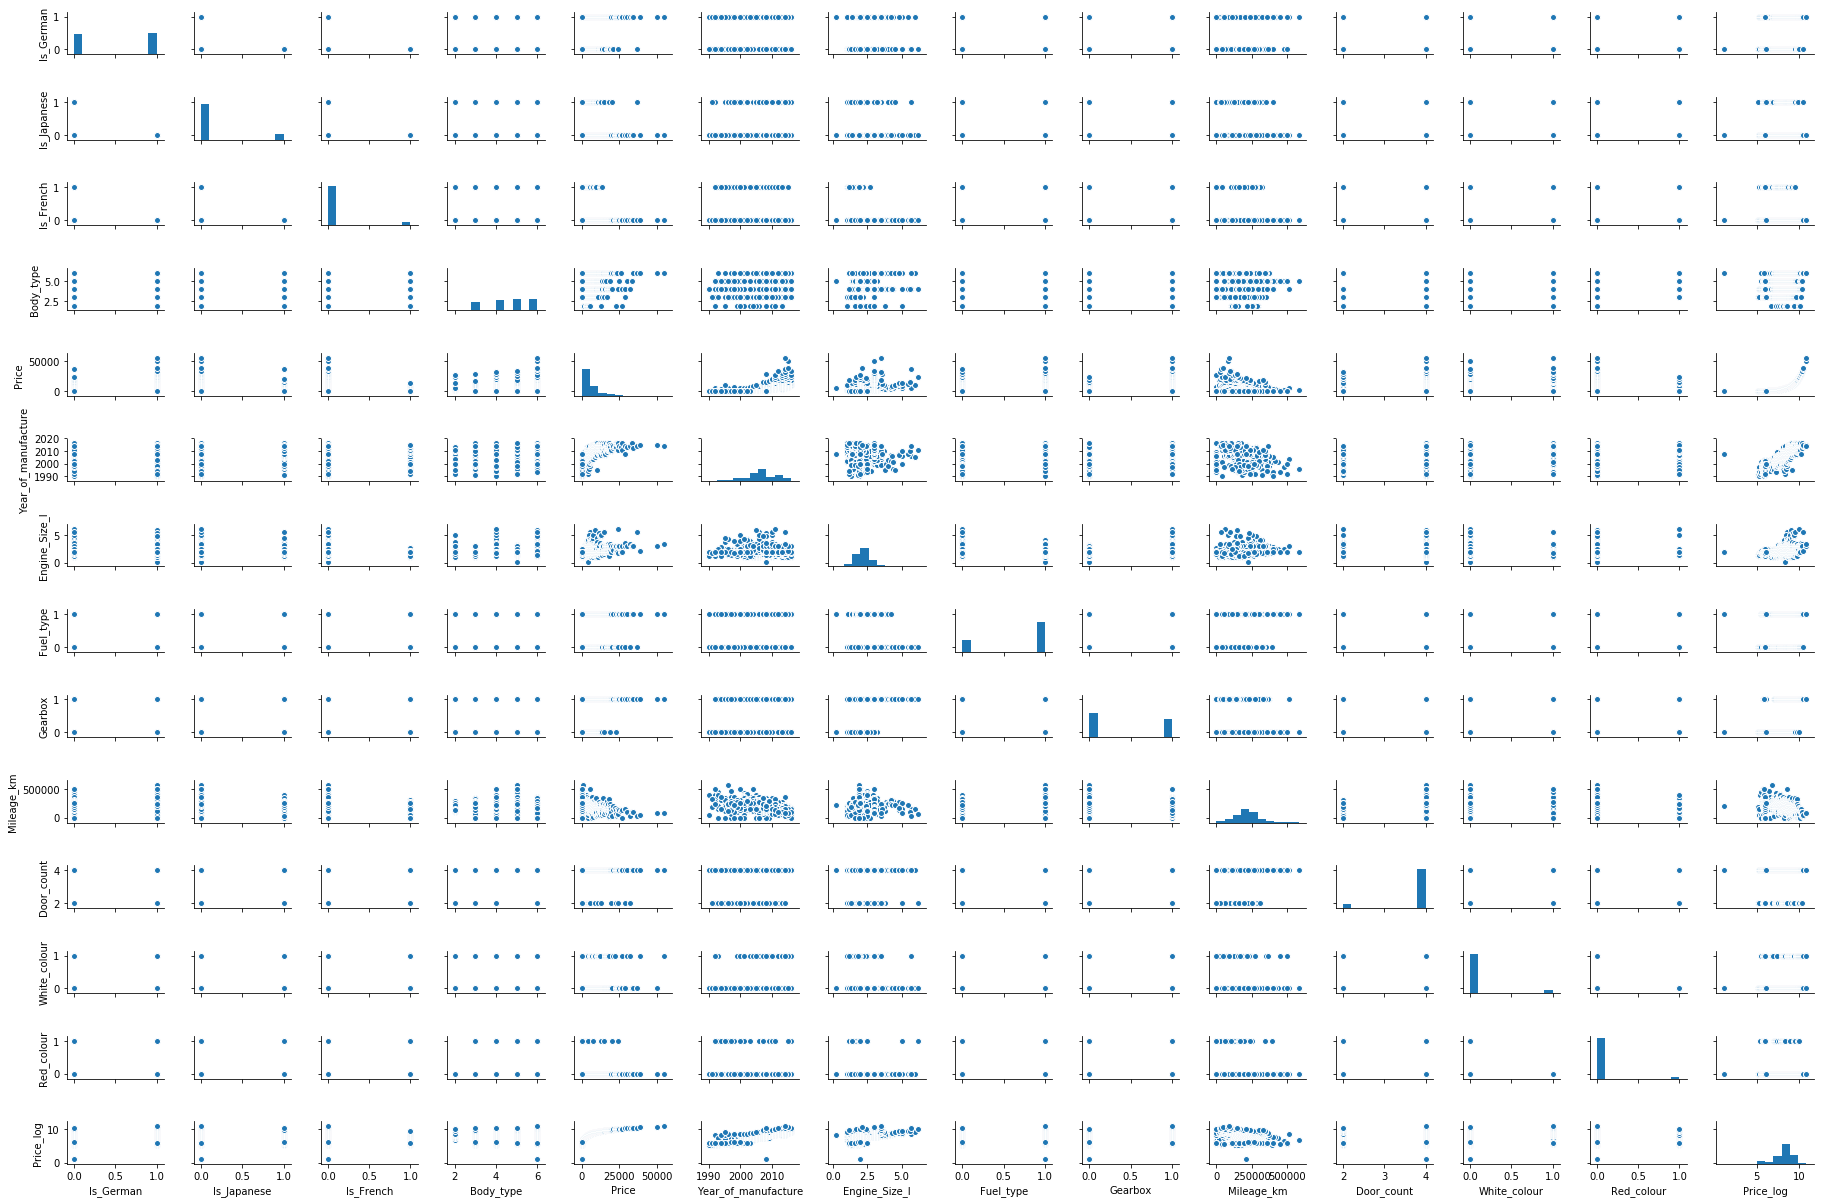

In [283]:
#Visualize the correlations
sns.pairplot(clean_car_ad_dataset, size = 1.2, aspect=1.5);

## Let's try modelling

### Statsmodels way

In [382]:
# #Create the target vector and feature matrix
m_all, K_all = patsy.dmatrices('Price_log ~ Year_of_manufacture + Engine_Size_l + Gearbox + Mileage_km + Body_type + Door_count + Fuel_type + Is_White + Is_Red + Is_German + Is_BMW + Is_Mercedes_Benz + Is_Japanese + Is_French', clean_car_ad_dataset)

#Linear Regression
car_ad_model_sms_all = sm.OLS(m_all, K_all)
car_ad_model_sms_all_fit = car_ad_model_sms_all.fit()
car_ad_model_sms_all_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Price_log   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     276.5
Date:                Tue, 17 Jul 2018   Prob (F-statistic):          2.49e-312
Time:                        15:14:52   Log-Likelihood:                -578.71
No. Observations:                 905   AIC:                             1187.
Df Residuals:                     890   BIC:                             1260.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            -307.6838      7.787    -39.511      0.000    -322.967    -292.400
Year_of_manufacture     0.1569      0.004     40.456      0.000       0.149       0.165
Engine_Size_l           0.3768      0.028     13.318      0.000       0.321       0.432
Gearbox                 0.1939      0.039      4.996      0.000       0.118       0.270
Mileage_km          -4.442e-07   2.47e-07     -1.802      0.072   -9.28e-07    3.97e-08
Body_type               0.0418      0.016      2.694      0.007       0.011       0.072
Door_count             -0.0238      0.031     -0.778      0.437      -0.084       0.036
Fuel_type               0.0644      0.040      1.601      0.110      -0.015       0.143
Is_White               -0.0297      0.062     -0.475      0.635      -0.152       0.093
Is_Red                 -0.0980      0.088     -1.117      0.264      -0.270       0.074
Is_German               0.2232      0.040      5.516      0.000       0.144       0.303
Is_BMW                  0.1798      0.052      3.466      0.001       0.078       0.282
Is_Mercedes_Benz        0.1356      0.073      1.855      0.064      -0.008       0.279
Is_Japanese             0.1903      0.050      3.778      0.000       0.091       0.289
Is_French              -0.2152      0.068     -3.175      0.002      -0.348      -0.082
==============================================================================
Omnibus:                      909.965   Durbin-Watson:                   1.763
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           167647.741
Skew:                          -4.144   Prob(JB):                         0.00
Kurtosis:                      69.161   Cond. No.                     1.12e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

> Results with just Year_of_manufacture: adj.R2 = 0.676, F-stat = 2070, Log-like = -860, Cond.No = 7.91e+05   
Results with just Year_of_manufacture and Engine Size: adj.R2 = 0.801, F-stat = 2002, Log-like = -616, Cond.No = 7.92e+05   
Results with just Year_of_manufacture, Engine Size and Mileage: adj.R2 = 0.801, F-stat = 1335, Log-like = -616, Cond.No. = 9.99e+07   
Results with just Year_of_manufac, Engine Size, Mileage and Fuel type: adj.R2 = 0.802, F-stat = 1007, Log-like = -613, Cond.No = 1.05e+08   
Results with just Year_of_manufac, Engine Size, Mileage, Fuel type and Gearbox: adj.R2 = 0.810, F-stat = 850, Log-like = -592, Cond. No = 1.10e+08   
Results with just Year_of_manufac, Engine Size, Mileage, Fuel type, Gearbox and Is_German: adj.R2 = 0.830, F-stat = 808, Log-like = -537, Cond.No = 1.10e+08   
Results with just Year_of_manufac, Engine Size, Mileage, Fuel type, Gearbox, Is_German and Is_French: adj.R2 = 0.837, F-stat = 727, Log-like = -516, Cond.No = 1.11e+08   
Results with just Year_of_manufac, Engine Size, Mileage, Fuel type, Gearbox, Is_German, Is_French and Is_Japanese: adj.R2 = 0.840, F-stat = 651, Log-like = -507, Cond.No = 1.11e+08

-7.161265106373716

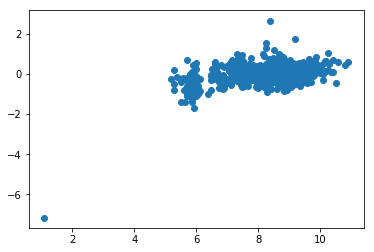

In [430]:
# Use statsmodels to plot the residuals# Use s 
residuals_sms = car_ad_model_sms_all_fit.resid
plt.scatter(m_all, residuals_sms)
residuals_sms.min()

In [462]:
#What's this really large residual?
print(np.argmin(residuals_sms))
clean_car_ad_dataset.iloc[834]

834


Price                       3.000000
Year_of_manufacture      2008.000000
Engine_Size_l               2.000000
Gearbox                     0.000000
Mileage_km             209000.000000
Body_type                   6.000000
Door_count                  4.000000
Fuel_type                   1.000000
Is_White                    0.000000
Is_Red                      0.000000
Is_German                   0.000000
Is_BMW                      0.000000
Is_Mercedes_Benz            0.000000
Is_Japanese                 0.000000
Is_French                   0.000000
Price_log                   1.098612
Name: 1758, dtype: float64

In [460]:
#Let's check this records out
clean_car_ad_dataset[clean_car_ad_dataset['Price'] == 3.0]
#Seems very unlikely that this car costs only €3

,Price,Year_of_manufacture,Engine_Size_l,Gearbox,Mileage_km,Body_type,Door_count,Fuel_type,Is_White,Is_Red,Is_German,Is_BMW,Is_Mercedes_Benz,Is_Japanese,Is_French,Price_log
1758,3.0,2008.0,2.0,0.0,209000.0,6.0,4.0,1.0,0,0,0,0,0,0,0,1.098612


In [456]:
clean_car_ad_dataset.iloc[834]

Price                       3.000000
Year_of_manufacture      2008.000000
Engine_Size_l               2.000000
Gearbox                     0.000000
Mileage_km             209000.000000
Body_type                   6.000000
Door_count                  4.000000
Fuel_type                   1.000000
Is_White                    0.000000
Is_Red                      0.000000
Is_German                   0.000000
Is_BMW                      0.000000
Is_Mercedes_Benz            0.000000
Is_Japanese                 0.000000
Is_French                   0.000000
Price_log                   1.098612
Name: 1758, dtype: float64

### Sklearn way

**Training and testing**

In [ ]:
X, y = clean_car_ad_dataset[['Year_of_manufacture', 'Engine_Size_l', 'Mileage_km', 'Fuel_type', 'Gearbox', 'Is_German',
                             'Is_BMW', 'Is_Mercedes_Benz', 'Is_French', 'Is_Japanese']], clean_car_ad_dataset['Price']

In [389]:
#Split the data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

### Choose the right model

TypeError: float() argument must be a string or a number, not 'Pipeline'

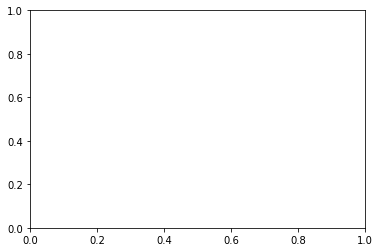

In [453]:
# Set up the plot
fig,ax = plt.subplots(1,1)

degree = 2
est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
est_fit = est.fit(X_train, y_train)

In [407]:
#Create the feature matrix and target vector
X, y = clean_car_ad_dataset[['Year_of_manufacture', 'Engine_Size_l', 'Mileage_km', 'Fuel_type', 'Gearbox', 'Is_German',
                             'Is_BMW', 'Is_Mercedes_Benz', 'Is_French', 'Is_Japanese']], clean_car_ad_dataset['Price']
y_log = np.log(y_train)

X1, y1 = X_train[['Year_of_manufacture', 'Engine_Size_l', 'Mileage_km', 'Fuel_type', 'Gearbox', 'Is_German',
                             'Is_BMW', 'Is_Mercedes_Benz', 'Is_French', 'Is_Japanese']], y_log

car_ad_model = LinearRegression()
car_ad_model_log = LinearRegression()

In [408]:
car_ad_model_log_fit = car_ad_model_log.fit(X1, y1)

In [394]:
#Fit the model with train values
car_ad_model_fit = car_ad_model.fit(X_train, y_train)

**Adjusted R-squared calculation**

In [ ]:
# adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-X.shape[1]-1)

**Cooks distance (residuals)**

In [ ]:
#model_fit=sm.OLS(yt_train, sm.add_constant(Xt_train)).fit()
#model_cooks=model_fit.get_influence().cooks_distance[0]
#leverage=np.flip(np.argsort(model_cooks),0)
#max(model_cooks)

**Piping + Lasso**

In [ ]:
alphas=[10**(float(i)/10) for i in np.arange(-100,10,1)]

for i in range(1,8):
    degree=i
    est = make_pipeline(PolynomialFeatures(degree), LassoCV(cv=4,alphas=alphas))
    fit3=est.fit(X_train, y_train)
    scores = cross_val_score(fit3, X_train, y_train, cv=4, scoring='mean_squared_error')
    y_predict=fit3.predict(X_train)
    mse_adj=round(R2_adj(y_predict,y_train,4),3)
    print(f"Degree: {i},   Naive Score: {round(fit2.score(X_train,y_train),3)},  Cross_Val: {round(np.mean(scores),2)},   MSE: {mse_adj}")

**Polynomial Models**

In [413]:
poly = PolynomialFeatures(3)
Xpoly = poly.fit_transform(X_train)



In [414]:
Xpoly

array([[1.000e+00, 2.006e+03, 2.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 2.006e+03, 1.600e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 2.004e+03, 3.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [1.000e+00, 1.999e+03, 2.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 2.002e+03, 4.200e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [1.000e+00, 2.000e+03, 1.600e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00]])

**Let's try to predict y_values, based on the current model and x_values**

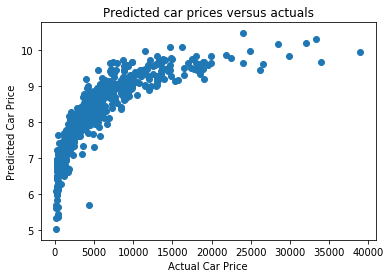

In [412]:
#Calculating training error
y_train_predicted_log = car_ad_model_log.predict(X1)

plt.scatter(y_train, y_train_predicted)
plt.title('Predicted car prices versus actuals')
plt.ylabel('Predicted Car Price')
plt.xlabel('Actual Car Price');


#mean_sq_error(y_train, y_train_predict)

In [294]:
#Do the cross-validation
from sklearn.cross_validation import cross_val_score

scores = cross_val_score(car_ad_model, X_train, y_train, cv = 5, scoring='r2')
print('The r-squared scores of cross validation:', str(scores))
print('The mean of r-squared scores is', str(round(scores.mean(), 3))+ '.\n')

scores = cross_val_score(car_ad_model, X_train, y_train, cv = 5, scoring='neg_mean_squared_error')
print('The mean squared error scores of cross validation:', str(-scores))
print('The mean of the mean squared error scores is:', str(round(-scores.mean(), 3)))

The r-squared scores of cross validation: [0.85334357 0.68178207 0.86167672 0.8353559  0.81637666] 

The mean of r-squared scores is 0.81.

The mean squared error scores of cross validation: [0.14644257 0.5570552  0.12849962 0.19416203 0.1934953 ] 

The mean of the mean squared error scores is: 0.244


In [390]:
#car_ad_model_fit = car_ad_model.fit(X_train, y_train)
#print('The score on the training data', str(car_ad_model.score(X_train, y_train)))
#print('The score on the testing data', str(car_ad_model_fit.score(X_test, y_test)))

### Try preprocessing

### Examing Residuals

KeyError: 834

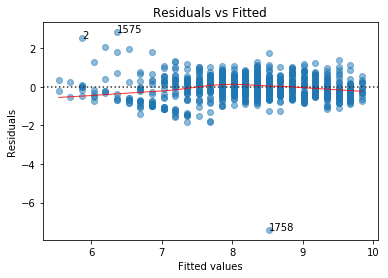

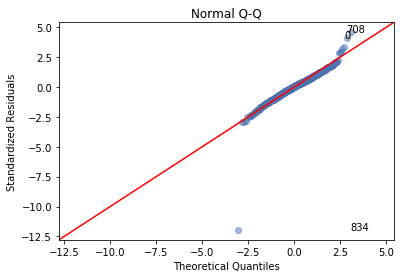

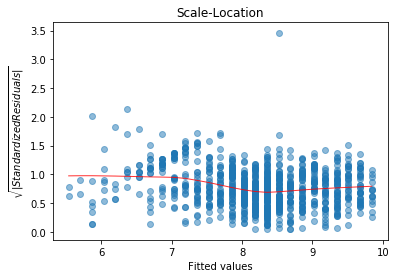

In [289]:
# Use diagnostic_plots python file to plot Year of manufacture results
diagnostic_plots(clean_car_ad_dataset['Year_of_manufacture'], np.log(clean_car_ad_dataset['Price']))

In [ ]:
#Explore residual extremes


In [ ]:
# Use diagnostic_plots python file to plot Engine Size (l) results
diagnostic_plots(clean_car_ad_dataset['Engine_Size_l'], np.log(clean_car_ad_dataset['Price']))

In [ ]:
# Use diagnostic_plots python file to plot Mileage (km) results
diagnostic_plots(clean_car_ad_dataset['Mileage_km'], np.log(clean_car_ad_dataset['Price']))

In [ ]:
# Use diagnostic_plots python file to plot Fuel type results
diagnostic_plots(clean_car_ad_dataset['Body_type'], np.log(clean_car_ad_dataset['Price']))